<a href="https://colab.research.google.com/github/gosantam/Tablas/blob/main/Conversores/coord2table_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# En proceso
- Para localizar las celdas se utiliza **YOLOv4** y para extraer el texto de dichas celdas **OCR**.

In [ ]:
import json
import cv2
from pathlib import Path
import matplotlib.pylab as plt
import numpy as np
import PIL

In [ ]:
def mostrarImagen(imagen):
    if len(imagen.shape)==3:
        img2= cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        # o equivalentemente, img2 = imagen[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
        plt.show()

## Dataset

- Imágenes con sus localizaciones en el formato YOLO

In [ ]:
%%capture
!wget https://www.dropbox.com/s/4iw05m7h0yvbogh/datasetYOLO.zip?dl=1 -O datasetYOLO.zip
!unzip datasetYOLO

- Predicciones con el texto y las localizaciones en el formato [xmin, xmax, ymin, ymax]

In [ ]:
%%capture
!wget https://www.dropbox.com/s/hkimh0bv1eq666k/bboxTrain.json?dl=0 -O bboxTrain.json
!wget https://www.dropbox.com/s/t7ja0s9k2ynpekd/bboxTest.json?dl=0 -O bboxTest.json

In [ ]:
anoTrain=json.loads(open('bboxTrain.json').read())
anoTest=json.loads(open('bboxTest.json').read())

## Ejemplo

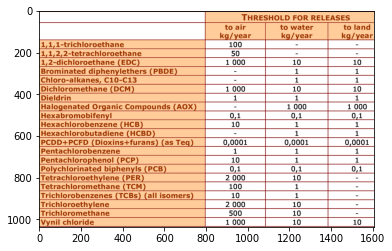

In [ ]:
img = cv2.imread(anoTrain[0]['file'])
mostrarImagen(img)

In [ ]:
l1=[(x[0]+x[1])/2 for x in anoTrain[0]['bbox']]
l2=[img.shape[1]-(x[2]+x[3])/2 for x in anoTrain[0]['bbox']]

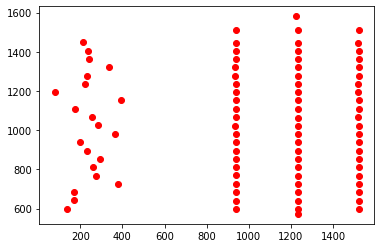

In [ ]:
plt.plot(l1,l2,'ro')

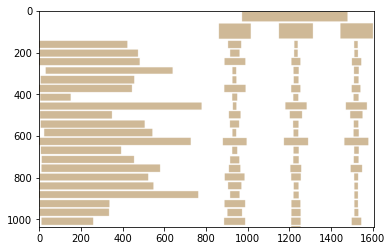

In [ ]:
img2 = np.zeros(shape=img.shape,dtype='uint8')+255
for b in anoTrain[0]['bbox']:
  x,y,w,h=b[0],b[2],b[1]-b[0],b[3]-b[2]
  cv2.rectangle(img2, (x, y), (x + w, y + h), (151, 185, 207), -1)
mostrarImagen(img2)

## Funciones

In [ ]:
def IoU_x(i1,i2):
  if i1[0] < i1[1] and i2[0] < i2[1]:
    x_left = max(i1[0], i2[0])
    x_right = min(i1[1], i2[1])
    if x_right < x_left: return 0.0
    intersection_leng = (x_right - x_left)
    i1_leng = i1[1]-i1[0]
    i2_leng = i2[1]-i2[0]
    iou = intersection_leng/float(i1_leng+i2_leng-intersection_leng)
    if 0 <= iou <= 1: return iou
    else: return 0
  else: return 0

def IoU_y(i1,i2):
  if i1[2] < i1[3] and i2[2] < i2[3]:
    x_left = max(i1[2], i2[2])
    x_right = min(i1[3], i2[3])
    if x_right < x_left: return 0.0
    intersection_leng = (x_right - x_left)
    i1_leng = i1[3]-i1[2]
    i2_leng = i2[3]-i2[2]
    iou = intersection_leng/float(i1_leng+i2_leng-intersection_leng)
    if 0 <= iou <= 1: return iou
    else: return 0
  else: return 0

def enlazadas_C(c1,c2):
  return IoU_x(c1,c2) > 0.01

def enlazadas_F(c1,c2):
  return IoU_y(c1,c2) > 0.01

In [ ]:
def qsort_C(bboxs,text):
  if bboxs == []:
    return bboxs,text
  else:
    bbox = bboxs[0]
    char = text[0]
    n = len(text[1:])
    bboxsL,textL = qsort_C([b for b in bboxs[1:] if b[2] < bbox[2]],[text[1:][i] for i in range(0,n) if bboxs[1:][i][2] < bbox[2]])
    bboxsU,textU = qsort_C([b for b in bboxs[1:] if b[2] >= bbox[2]],[text[1:][i] for i in range(0,n) if bboxs[1:][i][2] >= bbox[2]])
  
    return bboxsL + [bbox] + bboxsU, textL + [char] + textU

def qsort_F(bboxs,text):
  if bboxs == []:
    return bboxs,text
  else:
    bbox = bboxs[0]
    char = text[0]
    n = len(text[1:])
    bboxsL,textL = qsort_F([b for b in bboxs[1:] if b[0] < bbox[0]],[text[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]])
    bboxsU,textU = qsort_F([b for b in bboxs[1:] if b[0] >= bbox[0]],[text[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]])
  
    return bboxsL + [bbox] + bboxsU, textL + [char] + textU

def qsort_C2(L):
  if len(L) == 0: return L
  else:
    med = L[0]
    LL = qsort_C2([l for l in L[1:] if l[1][0][0] < med[1][0][0]])
    LU = qsort_C2([l for l in L[1:] if l[1][0][0] >= med[1][0][0]])
    return LL + [med] + LU

def qsort_F2(L):
  if len(L) == 0: return L
  else:
    med = L[0]
    LL = qsort_F2([l for l in L[1:] if l[1][0][2] < med[1][0][2]])
    LU = qsort_F2([l for l in L[1:] if l[1][0][2] >= med[1][0][2]])
    return LL + [med] + LU

def sort_C(columns):
  L = qsort_C2([(columns[c]['text'],columns[c]['bbox']) for c in columns])
  return {i+1:{'text':L[i][0],'bbox':L[i][1]} for i in range(0,len(L))}
  

def sort_F(rows):
  L = qsort_F2([(rows[c]['text'],rows[c]['bbox']) for c in rows])
  return {i+1:{'text':L[i][0],'bbox':L[i][1]} for i in range(0,len(L))}

In [ ]:
def enlazar_columnas(coords,text,columns={},i=1):
  if len(text)==0 or len(coords)==0:
    for i in columns:
      n = len(columns[i]['bbox'])
      for j in range(0,n):
        c = columns[i]['bbox'][j]
        t = columns[i]['text'][j]
        for k in columns:
          if k != i:
            if len([1 for cc in columns[k]['bbox'] if enlazadas_C(cc,c)])>0:
              columns[k]['bbox'].append(c)
              columns[k]['text'].append(t)
    columns = sort_C(columns)
    for i in columns: columns[i] = qsort_C(columns[i]['bbox'],columns[i]['text'])[1]
    return columns
  else:
    columns[i] = {}
    columns[i]['text'] = [text[0]]
    columns[i]['bbox'] = [coords[0]]
    coords = coords[1:]
    text = text[1:]
    ids = []
    n = len(text)
    for id in range(0,n):
      if len([1 for c in columns[i]['bbox'] if enlazadas_C(coords[id],c)]) == len(columns[i]['bbox']):
        columns[i]['text'].append(text[id])
        columns[i]['bbox'].append(coords[id])
        ids.append(id)
    coords = [j for i, j in enumerate(coords) if i not in ids]
    text = [j for i, j in enumerate(text) if i not in ids]
    return enlazar_columnas(coords,text,columns,i+1)

In [ ]:
def enlazar_filas(coords,text,rows={},i=1):
  if len(text)==0 or len(coords)==0:
    for i in rows:
      n = len(rows[i]['bbox'])
      for j in range(0,n):
        c = rows[i]['bbox'][j]
        t = rows[i]['text'][j]
        for k in rows:
          if k != i:
            if len([1 for cc in rows[k]['bbox'] if enlazadas_F(cc,c)])>0:
              rows[k]['bbox'].append(c)
              rows[k]['text'].append(t)
    rows = sort_F(rows)
    for i in rows: rows[i] = qsort_F(rows[i]['bbox'],rows[i]['text'])[1]
    return rows
  else:
    rows[i] = {}
    rows[i]['text'] = [text[0]]
    rows[i]['bbox'] = [coords[0]]
    coords = coords[1:]
    text = text[1:]
    ids = []
    n = len(text)
    for id in range(0,n):
      if len([1 for c in rows[i]['bbox'] if enlazadas_F(coords[id],c)]) == len(rows[i]['bbox']):
        rows[i]['text'].append(text[id])
        rows[i]['bbox'].append(coords[id])
        ids.append(id)
    coords = [j for i, j in enumerate(coords) if i not in ids]
    text = [j for i, j in enumerate(text) if i not in ids]
    return enlazar_filas(coords,text,rows,i+1)

In [ ]:
def data2matriz(columns,rows):
  pass

In [ ]:
def matriz2latex(rows):
  c = ''
  print('\\begin{table}')
  c = c+'\\begin{table} \n'
  print('\\begin{center}')
  c = c+'\\begin{center} \n'
  print('\\begin{tabular}{|'+'|'.join(['c' for i in range(0,max([len(f) for f in rows]))])+'|}')
  c = c+'\\begin{tabular}{|'+'|'.join(['c' for i in range(0,max([len(f) for f in rows]))])+'|} \n'

  anterior = rows[0][0]
  k1,k2 = 0,0
  for i in range(0,len(rows)-1):
    cell = rows[i+1][0]
    if cell == anterior:
      k2+=1
    else:
      if k2>k1:
        rows[k1][0] = '\multirow{'+str(k2-k1+1)+'}{*}{'+anterior+'}'
        for j in range(k1+1,k2+1): rows[j][0]=''
      k2+=1
      k1=k2
      anterior = cell
  if k2>k1:
    rows[k1][0] = '\multirow{'+str(k2-k1+1)+'}{*}{'+anterior+'}'
    for j in range(k1+1,k2+1): rows[j][0]=''
  
  for i in range(0,len(rows)):
    # Tratando las multi-columnas
    anterior = rows[i][0]
    k1,k2,j=0,0,0
    for cell in rows[i][1:]:
      if anterior == cell:
        k2+=1
      else:
        if k2 > k1:
          rows[i][rows[i].index(anterior)] = '\multicolumn{'+str(k2-k1+1)+'}{|c|}{'+anterior+'}'
          for r in range(0,k2-k1):
            rows[i].remove(anterior)
        anterior = cell
        k1,k2=0,0
    if k2 > k1:
      elementos[anterior] = (k1,k2)
      rows[i][rows[i].index(anterior)] = '\multicolumn{'+str(k2-k1+1)+'}{|c|}{'+anterior+'}'
      for r in range(0,k2-k1):
        rows[i].remove(anterior)
    if rows[i][0] == '':
      print('\\cline{2-'+str(max([len(f) for f in rows]))+'}')
      c = c+'\\cline{2-'+str(max([len(f) for f in rows]))+'} \n'
    else:
      print('\\hline')
      c = c+'\\hline \n'
    print(' & '.join(rows[i])+' \\\\')
    c = c+' & '.join(rows[i])+' \\\\ \n'  
  print('\\hline')
  c = c+'\\hline \n'
  print('\\end{tabular}')
  c=c+'\\end{tabular} \n'
  print('\\end{center}')
  c=c+'\\end{center} \n'
  print('\\end{table}')
  c=c+'\\end{table} \n'
  return c

## Pruebas

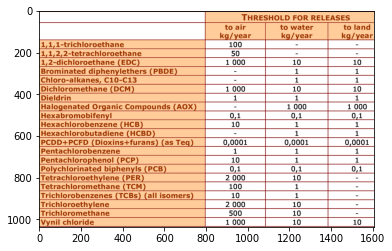

In [ ]:
img = cv2.imread(anoTrain[0]['file'])
mostrarImagen(img)

In [ ]:
C = enlazar_columnas(anoTrain[0]['bbox'],anoTrain[0]['text'])
print(C)

{1: ['1,1,1-trichloroethane', '1,1,2,2-tetrachloroethan:', '1,2-dichloroethane (EDC)', 'rominated diphenvlethers (PBDE', 'Chloro-alkanes, C10-C1:', 'Dichloromethane (DCM', 'Dieldrin', 'Halogenated Oraanic Compounds (AOX)', 'Hexabromobifenvl', 'Hexachlorobenzene (HCB)', 'lexachlorobutadiene (HCBD', 'PCDD+PCFD (Dioxins+furans) (as Tea', 'Pentachlorobenzene', 'Pentachlorophenol (PCE', 'Polychlorinated biphenvls (PCI', 'Tetrachloroethviene (PER)', 'Tetrachloromethane (TCM)', 'Trichlorobenzenes (TCBs) (all isomers)', 'Trichloroethvlene', 'Trichloromethane', 'Vvnil chloride'], 2: ['Wildlife Criterion  (pg/L)', 'THRESHOLD FOR RELEASE:', 'THRESHOLD FOR RELEASE:', 'to land  ka/vear', 'to land  ka/vear', 'to water  ka/vear', 'to land  ka/vear', 'to air  ka/vear', 'to air  ka/vear', 'to air  ka/vear', 'Mercury Study Report to Congress', '100', '', '100', '', '100', '', '', '', '50', '', '50', '', '50', '', '', '', '10', '1000', '1000', '10', '10', '1000', '10', '1', '1', '1', '1', '1', '', '', ''

In [ ]:
F = enlazar_filas(anoTrain[0]['bbox'],anoTrain[0]['text'])
print(F)

{1: ['THRESHOLD FOR RELEASE:'], 2: ['to air  ka/vear', 'to water  ka/vear', 'to land  ka/vear'], 3: ['1,1,1-trichloroethane', '100', '', ''], 4: ['1,1,2,2-tetrachloroethan:', '50', '', ''], 5: ['1,2-dichloroethane (EDC)', '1000', '10', '10'], 6: ['rominated diphenvlethers (PBDE', '', '1', '1'], 7: ['Chloro-alkanes, C10-C1:', '', '1', '1'], 8: ['Dichloromethane (DCM', '1 000', '10', '1C'], 9: ['Dieldrin', '1', '1', '1'], 10: ['Halogenated Oraanic Compounds (AOX)', '', '1000', '1000'], 11: ['Hexabromobifenvl', '0.1', '0.1', '0.1'], 12: ['Hexachlorobenzene (HCB)', '10', '1', '1'], 13: ['lexachlorobutadiene (HCBD', '', '1', '1'], 14: ['PCDD+PCFD (Dioxins+furans) (as Tea', '0.0001', '0.0001', '0.0001'], 15: ['Pentachlorobenzene', '1', '1', '1'], 16: ['Pentachlorophenol (PCE', '10', '1', '1'], 17: ['Polychlorinated biphenvls (PCI', '0,1', '0,1', '0,1'], 18: ['Tetrachloroethviene (PER)', '2 00d', '10', ''], 19: ['Tetrachloromethane (TCM)', '100', '1', ''], 20: ['Trichlorobenzenes (TCBs) (all 

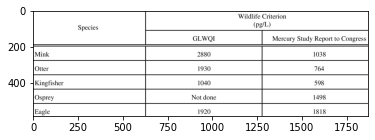

In [ ]:
img = cv2.imread(anoTrain[3]['file'])
mostrarImagen(img)

In [ ]:
l1=[(x[0]+x[1])/2 for x in anoTrain[3]['bbox']]
l2=[img.shape[1]-(x[2]+x[3])/2 for x in anoTrain[3]['bbox']]

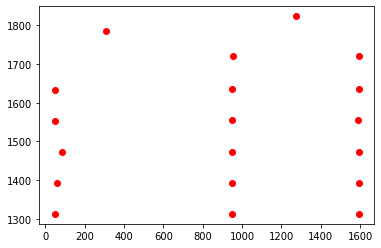

In [ ]:
plt.plot(l1,l2,'ro')

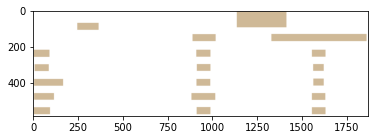

In [ ]:
img2 = np.zeros(shape=img.shape,dtype='uint8')+255
for b in anoTrain[3]['bbox']:
  x,y,w,h=b[0],b[2],b[1]-b[0],b[3]-b[2]
  cv2.rectangle(img2, (x, y), (x + w, y + h), (151, 185, 207), -1)
mostrarImagen(img2)

In [ ]:
C = enlazar_columnas(anoTrain[3]['bbox'],anoTrain[3]['text'])
print(C)

{1: ['Mink', 'Otter', 'Kingfisher', 'Osprev', 'Eagle'], 2: ['Species'], 3: ['GLWOI', '2880', '1930', '1040', 'Not done', '1920'], 4: ['Wildlife Criterion  (pg/L)', 'Mercury Study Report to Congress', '7164'], 5: ['Wildlife Criterion  (pg/L)', 'Mercury Study Report to Congress', 'Mercury Study Report to Congress', '1038', '7164', '7164', '598', '1498', '1818']}


In [ ]:
F = enlazar_filas(anoTrain[3]['bbox'],anoTrain[3]['text'])
print(F)

{1: ['Species', 'Wildlife Criterion  (pg/L)'], 2: ['GLWOI', 'Mercury Study Report to Congress'], 3: ['Mink', '2880', '1038'], 4: ['Otter', '1930', '7164'], 5: ['Kingfisher', '1040', '598'], 6: ['Osprev', 'Not done', '1498'], 7: ['Eagle', '1920', '1818']}
